# Correlated-k Distribution
## Aka Black Magic
### Let's explain it anyway

Most of the papers start with the folowing equation to explain the method:

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-k_\nu u} d\nu $$

However, I think it really helps to take a step back and examine the equation this one *comes* from, and what in reality is the equation we actually want to solve: the above is just a simplified version. 

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-\int_{z_1}^{z_2} k(\nu,P,T) \rho dz} d\nu $$

This equation gives the transmission fraction $T_t$ due to a single constituent in the atmosphere. $\Delta \nu$ is the width of frequencies you care about; this can be the total spectrun your instrument can examine, the spectral resolution of said instrument, or just the width of a single line. (For our purposes it'll usually be the resolution--determining what exactly a single spectel, "spectral pixel," would see). $\nu$ itself is just any individual frequency. k is the absorption coefficient for an individual species [2], which depends on frequency, but also pressure P and temperature T. z measures the length of the path we care about, with $z_1$ and $z_2$ being the start and end, respectively. $\rho$ is the density, which is most likely a function of position. 

Ultimately, the goal we have is to find the transmission $T_t$ for every species. The difficult part of this is the integration over frequency, as k's dependence on frequency regularly looks something like this [3]:

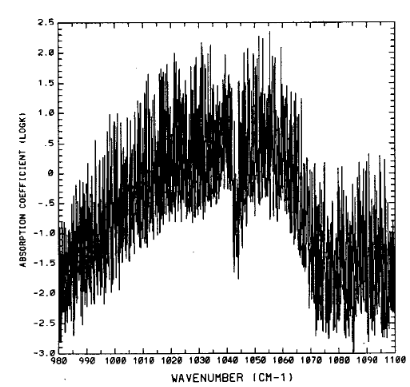

There is a lot of information contained in those spikes, and as such when we numerically integrate over frequency we have to sample a lot of points to capture all those spikes. This is not ideal and can seriously slow down code. The Correlated-k Distribution method seeks to solve this problem by changing what we integrate over. 

At this point we may return to the simpler equation. If we assume P and T do *not* change k and that it only depends on the frequency, we can pull it out of the z integral.

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-k(\nu) \int_{z_1}^{z_2} \rho dz} d\nu $$

The integral itself is now just over density, so we replace it with a single value "u" which stands in for the amount of material we're dealing with. In the end we only care about the total amount of material, not the densities it has at different levels. Naturally when actually calculating you need to be careful with units. We also tend to replace $k(\nu)$ with $k_\nu$.

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-k_\nu u} d\nu $$

This is the transmission assuming k depends only on frequency for a single constituent of the atmosphere. This is simple enough for us to perofrm some sanity checks. If $k_\nu$ is constant with frequency, that is we are integrating over a small band or a smooth area of the spectrum, the result is:

$$ T_t = e^{-k_\nu u} $$

As the integral is over a constant, the normalization factor out front simply cancels everything out. In the specific case of no absorption, $k_\nu=0$, we simply get

$$ T_t = 1 $$

Which is to say everything transmits. This also applies when u=0. In this model it is not possible to lower transmission to zero, but in reality we can surely make u large enough that not even a single photon would get through. 

Now, we do not want to integrate over $\nu$. Let us instead try to integrate over k. We can change variables somewhat easily:

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-k_\nu u} d\nu = \int_0^\infty f(k) e^{-k u} dk $$

This is simply stated in [1] but we want a little more justificaiton for this fundamental step. For now, f(k) is just some arbitrary function of k. 

Logically the change of variables makes sense, f(k) is an arbitrary function that can take any form, so it can take any role we wish in making the integrals equal, including simply recreating the previous integral (and its normalization factor) and canceling the exponential term. So long as there are no discontinuities it must at least be possible to do this. 

In order for this transformation to work, f(k) must be normalized on the range k to infinity, otherwise the u=0 condition would not be met. This gives us a hint as to what f(k) actually is: it's the probability distribution function (PDF) of k for a "randomly chosen" $\nu$. If $\nu$ was chosen randomly on its bounds, the height of f(k) would show how likely a certain value of k was to be chosen. This is best illustrated with a graph from [1]:

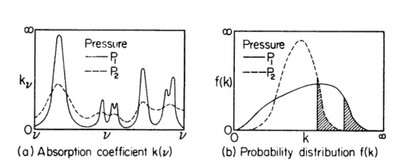



This is a somewhat idealized representation of the transformation taking place here. On the left we have two different absorption coefficient functions $k(\nu)$, on the right we have their corresponding f(k) probability distribution functions. The shaded areas simply point out the highest k-values, which correspond to the peaks in $k(\nu)$. Note that the f(k) function is smooth and only has one maximum. This is often (but not always) the case. 

At this point I should point out that while we are creating a probability density function, what we are actually calculating doesn't have anything to do with proability, this is just a trick. What we really extract from this is not the chance of something occuring, but rather the density of certain values: the "most probable" k values are simply the ones that show up most often across the frequency domain, we are just sorting them, examining their "distribution" if you will; part of the name of this procedure. (The correlated part comes later). 

If one integrates f(k) over k, you get g(k), the cumulative probability distribution function (CDF). Purely analytically this is not always easy to do, but numerically it's always very simple: if we have f(k) we simply add together a point and all its previous points to get that value of g(k). g(k) will go from 0 to 1 over the bounds. This, rather importantly, will remove any hills or valleys present in f(k) as g(k) is a strictly increasing value since you can't have a negative probability of anything. These types of functions are *easy* to numerically integrate with minimal sampling. 

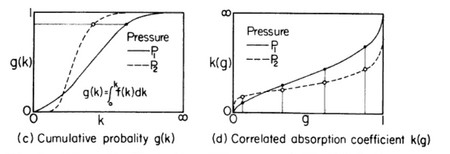

However, we do not have g(k) in our expression, how can we get it?

Invert it. As g(k) is a "one to one" function, its inverse k(g) is guaranteed to exist and also be one to one. And if we have k itself in terms of g, we can perform another change of variables on our transmission [3]:

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-k_\nu u} d\nu = \int_0^1 e^{-k(g) u} dg $$

Note that even though we don't have an arbitrary function, the $1/\Delta \nu$ vanished here. This is because it was a normalization factor, and as we are only integrating from 0 to 1 over g, the normalization factor is one and thus vanishes. This form of the transmission is much easier to integrate numerically, as k(g) is smooth. The presence of the exponential does not hurt this, as $e^x$ is also smooth and increasing. So by changing variables several times we can turn a nightmarish integral over frequency to a simple one over the cumulative probability distribution. An unusual integral to be sure, especially since there's no probability here, but the trick works. That nasty integral from before has become much simpler:

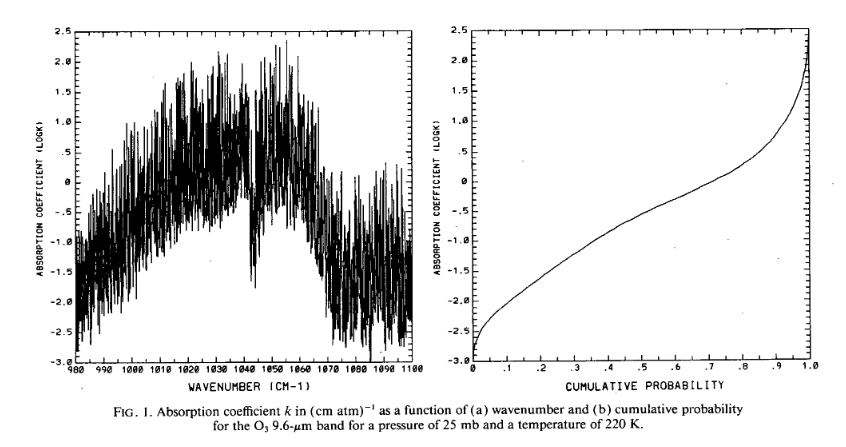

The problem is that we made an assumption in deriving this relation. That assumption was that k only changed with frequency. This is *not* true in the cases we care about, as when modeling radiative transfer through an atmosphere, both pressure and temperature vary wildly--though usually P and T can be tied to the single value of altitude. 

Wouldn't it be nice if the change of variables from frequency to g would work in the general case as well? That is, if... [3]

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-\int_{z_1}^{z_2} k(\nu,P,T) \rho dz} d\nu = \int_0^1 e^{-\int_{z_1}^{z_2} k(g,P,T) \rho dz} dg $$

Problem is, no, we can't just declare this to be absolutely true, mathematically it isn't valid. P and T could change too much. *However,* we don't care about being *perfect*, we just care about being *accurate enough* as we are making a simulation. So, what approximations and assumptions do we need to make to use the above relation as though it were true?

Two, it turns out, outlined in [3]. I'm not going through rigorous mathematical justificaitons here, but they turn out to be:

1) That any two arbitrary frequencies that have the same k value will have the same value at any pressure and temperature.

2) That if one frequency has a higher k than another frequency, that k will remain higher no matter what change occurs to the pressure or the tempreature. 

In a more genreal sense, we need to assume that the k values at verious frequencies are "correlated" to each other. The correlated-k distribution method *assumes* this to be true. Is it? Well, in our little toy graph from earlier

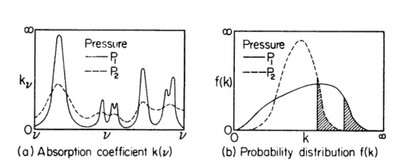

We can see correlation. Specifically, note that the high peaks are still high peaks in both pressures displayed here, and that the low peaks are still low. The *relative* sizes have changed, but larger ks are still larger than smaller ks, and the rough shape of the spectrum is maintained. Some of the finer features are admittedly lost as the pressure changes, so those places are where errors in the correlated-k distribution method will arise.

There is another way to check for correlation besides just eyeballing the spectra: you can calculate out g-functions for two different conditions and plot them against each other, such as in [3].

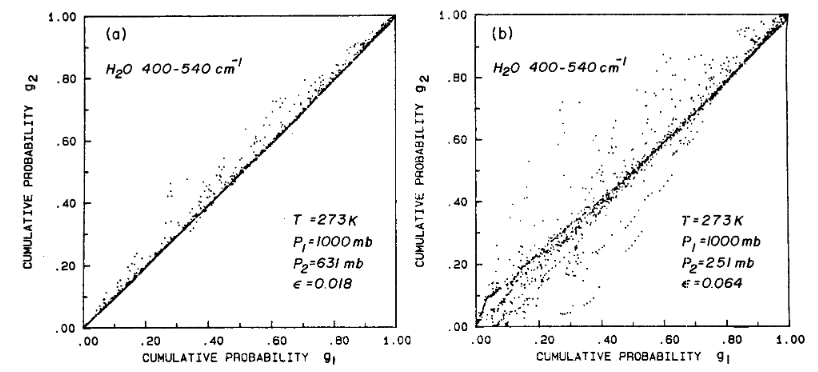

The left situation has greater correlation and thus the correlated-k method would have less errors in that regime when compared to the right situation. 

What about a more realistic $k(\nu)$ situation? From [2] we have a series of images that illustrate actual demonstrations of this...

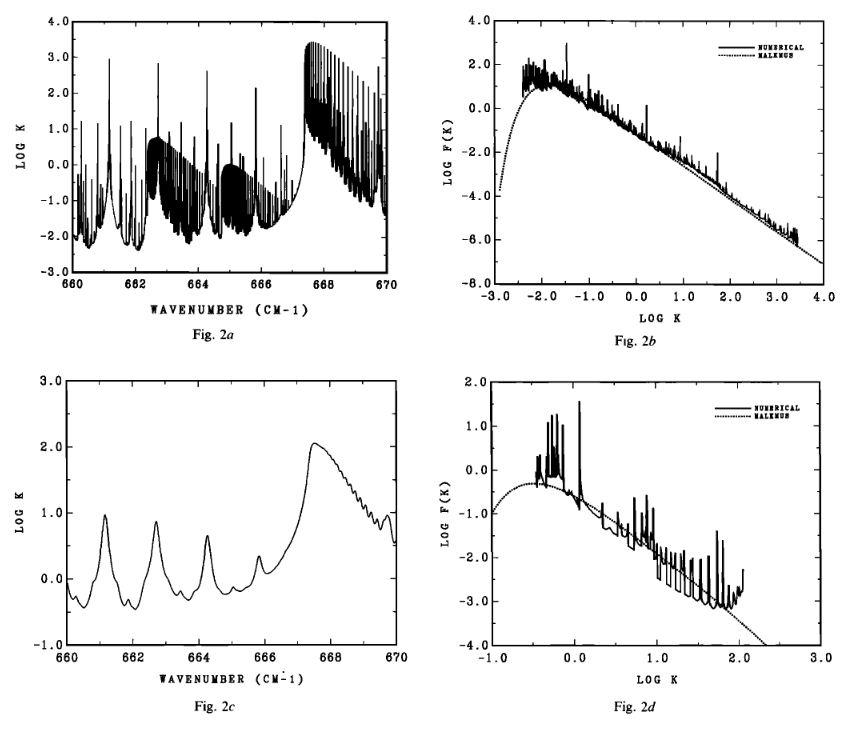

What we have here are on the left two different $k(\nu)$ spectrums, and on the right f(k)'s extracted from them. We can see several things here. First of all, in a realistic situation f(k) functions don't tend to be smooth--which is why we need to transform again into g(k). One thing we *can* tell is that despite there being clear differences between the spectrums of fig 2a and 2c, they have similar *relative* shapes, which means the corelated-k distribution method can be applied to them. 2a and 2c eare just slices of a much larger set of spectrums at different P and T conditions--the idea is that all of them are correlated to each other. One could imagine a three dimensional sheet that shows $k(\nu)$ for every altitude, and that fig 2a and 2c are just specific altitudes. 

Once we obtain f(k) values we naturally turn them into g(k) values, and then flip to k(g).

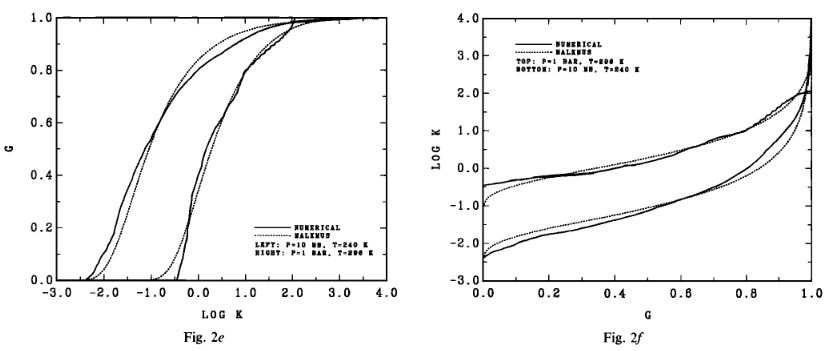

Note that these functions are smooth and thus easy to integrate, which is the entire point. 

So in the end, for well-behaved situations, we *can* turn the integral over frequency to an integral over g, the CDF. This will, in theory, allow us to easily obtian $T_t$, or at least obtian it with far less work than we would have previously. None of the transformation steps require an actual integral: f(k) can be found through monte carlo methods (Though [2] uses a more complicated but well-defined approach), g(k) can be found through simple additions, and k(g) through an inverse operation. 

To be clear, the following expression IS the correlated k-distribution method.

$$ T_t = \int_0^1 e^{-\int_{z_1}^{z_2} k(g,P,T) \rho dz} dg $$

This does leave open the question of *how* exactly to pull this off, we have a qualitative understanding of what we're doing, but are left in the weeds as to how to actually implement this. Before we get to that, however, I think a demonstration is in order.

## Correlated k Distribution demonstration

### Coded it up myself!

So, let's take a somewhat simple funciton that still has all the features we'd want from a somewhat complicated frequency distribution. We chose

$$ k = |sin(\frac{1}{\nu})| $$

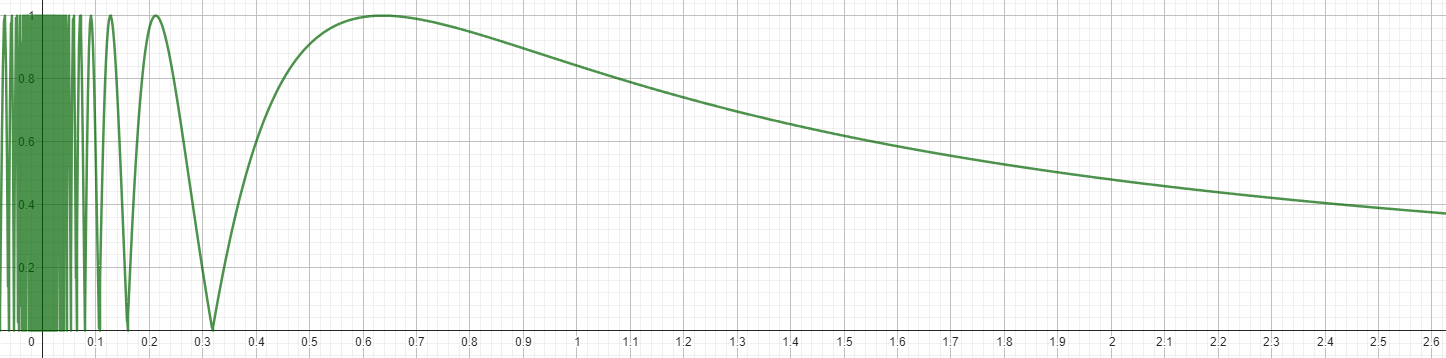

Complicated enough that analytical is out of the quesiton, positive everywhere, lots of spikes, but still some obvious large-scale behavior. We decided to declare the range to be from 0 to $2\pi$. First, we generate the PDF f(k) through a monte-carlo approach. (There are better ways to do this, this was just the obvious one).

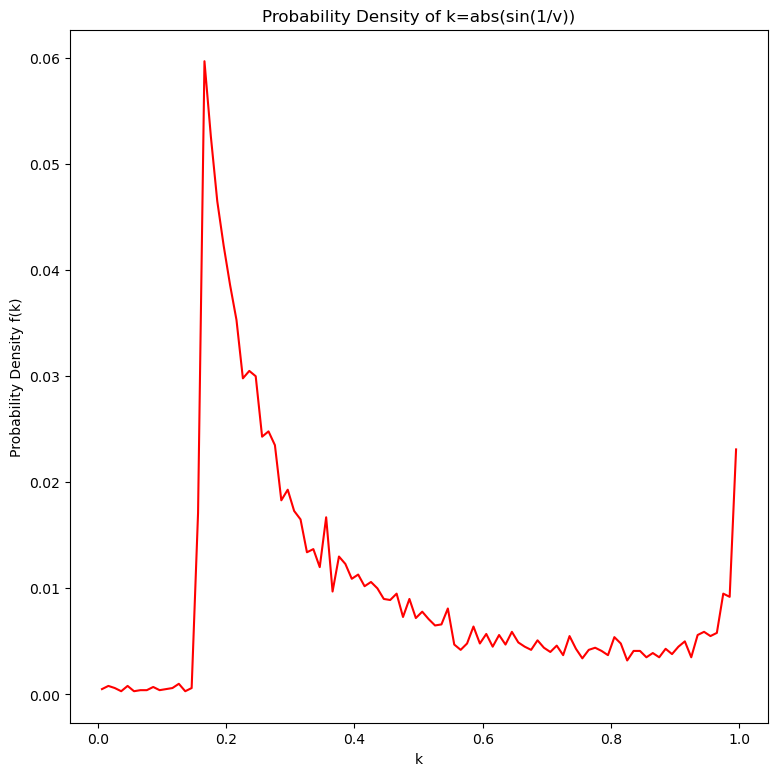

In [1]:
import math
import random 
import matplotlib.pyplot as plt

def funcEval(x):
    return abs(math.sin(1.0/x))
    # This is the function f(x), that is, it gives us y. We want the PDF of y in the end. 

# declare our range of values. 
lowerBound = 0.0
upperBound = 6.28

# how many times to we want to randomly evaluate?
# we've kept this value low in order to show some visible errors.
evaluations = 10000

# how many bins do you want to sort your y values into at the end? 
# this determines the "resolution" of the calculated PDF.
bins = 100

#This array will store our y points for later analysis. 
yValues = []

i = 1
while (i <= evaluations):
    #This loop evaluates the function "evaluations" times and records all found y values.
    yValues.append(funcEval(lowerBound + random.random()*(upperBound - lowerBound)))
    i = i+1

binLocations = [0.0]*bins
binValues = [0.0]*bins
#One array holds where the bins are, the other holds how many "hits" we get in each bin.

# find the locations of the bins. Remember that we are binning over the range (y), not the domain (x).
# this means we need to find the minimum and maximum values of yValues. 
# fortunately that's trivial
minRange = min(yValues)
maxRange = max(yValues)

i = 0
while (i < bins):
    binLocations[i] = minRange + (maxRange - minRange)*((0.5+float(i))/bins)
    i = i+1

# for code clarity, save the HALF width of a single bin. This number will be used a lot. 
hWidth = (maxRange - minRange)*(0.5/bins)
    
# next we sort into bins. This algorithm is rather primitive. Points that are exactly halfway round up
# unless they are the last point. 

i = 0
while (i < evaluations):
    j = 0
    while (j < bins):
        if (j != bins-1):
            if ( (yValues[i] >= binLocations[j]-hWidth) and (yValues[i] < binLocations[j]+hWidth) ):
                binValues[j] = binValues[j] + 1
        else: #aka if we are at the end and need to account for the highest possible value.
            if ( (yValues[i] >= binLocations[j]-hWidth) and (yValues[i] <= binLocations[j]+hWidth) ):
                binValues[j] = binValues[j] + 1            
        j = j+1
    i = i+1

# now that everything has been binned, we need to normalize the values.
# fortunately we know how many evaluations there were. 

i=0
while (i < bins):
    binValues[i] = binValues[i]/evaluations
    i=i+1
    
# now we have normalized binValues and accurate binLocations. We can now plot it!

fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Probability Density f(k)')
ax.set_title('Probability Density of k=abs(sin(1/v))')
ax.plot(binLocations, binValues, color='r')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
# ax.set_yscale("log") # Found in matplotlib's documentation.
# ax.legend()


# Bin values need to be normalized so the addition of all bins equals 1.
# then plot with matplotlib. Consider result. Make lots of plots and compare always.

This is f(k). If we had bothered with more resolution (by increasing `evaluations`) we could have made a very smooth graph here, but there will always be errors and sometimes the spikes are *very* fine. The small spikes visible in the graph are errors from the limited resolution. The *real* spikes are at 0.2 and 1.0, these values are both significantly more common than the ones around them. This is because there is a large hump in the function at $\nu = 0.6$ where the function has low slope and equals values near to one, so values around here are rather common. The k=0.2 probability comes from the fact that we're going out all the way to $2\pi$, and the value of k hardly changes at all out there, accumulating more and more "time" as we go in. If we went even further we would actually shift the spike at k=0.2 lower in k-value, hence the massive drop on the graph above. 

Regardless, all these spikes, both from errors and from different real likely k values, make integration harder. This is why we convert f(k) into g(k), to get something guaranteed to be smooth. That code is below. 

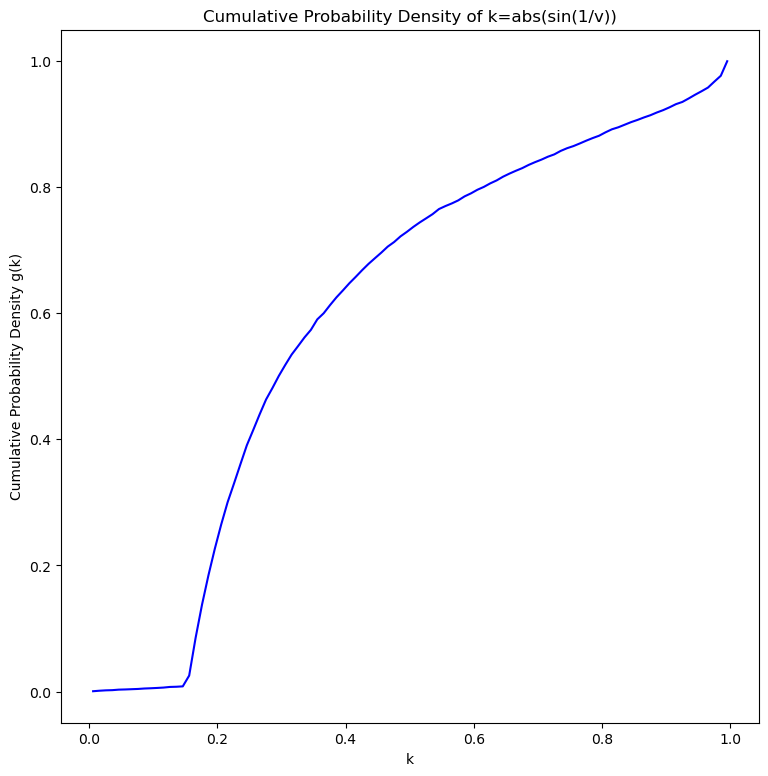

In [2]:
# to turn the PDF into a CDF we need to add the probabilities up to 1 rather than keep them all in separate bins.

binCumulative = [0.0] * bins

# the first value is the same
binCumulative[0] = binValues[0]

i = 1
while (i < bins):
    binCumulative[i] = binValues[i] + binCumulative[i-1]
    i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Cumulative Probability Density g(k)')
ax.set_title('Cumulative Probability Density of k=abs(sin(1/v))')
ax.plot(binLocations, binCumulative, color='b')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
# ax.set_yscale("log") # Found in matplotlib's documentation.
# ax.legend()

And THIS is easy to integrate. Even if you miss the sharp turn just below k=0.2 the overall behavior can still be captured! Naturally we still need to invert it, but for a computer this is trivial.

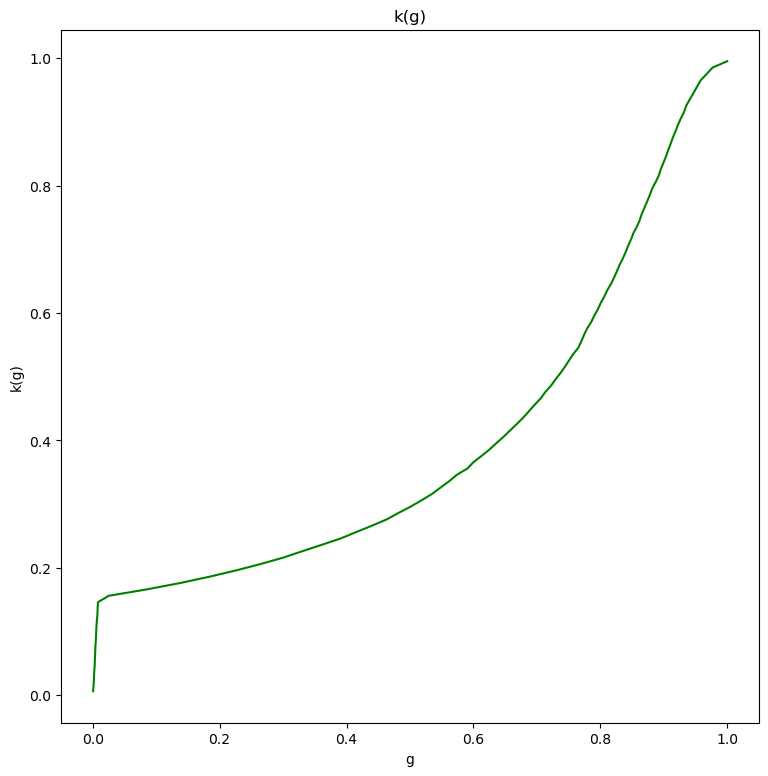

In [3]:
fig, ax = plt.subplots()
ax.set_xlabel('g')
ax.set_ylabel('k(g)')
ax.set_title('k(g)')
ax.plot(binCumulative, binLocations, color='g')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# Setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

And for a single value of P and T, we are done. Naturally the full implementation would account for varying P and T, but we only used a single function as this demonstration. 

We will point out that we have a sharp lurch near the start at g=0.0, as it's very unlikely to *have* 0 as a result, but not impossible. Most $k(\nu)$ functions in real life won't have this situation occur. 

## Practically Using This

### We need an instruciton manual

So how is this actually DONE? Like, given a $k(\nu, P, T)$, how do we get our transmission? 

Well, let's assume we're dealing with a spherically symmetric atmosphere, which is our primary focus. That way, $k(\nu,P,T)$ becomes $k(\nu,z)$, that is it depends only on the frequency and the altitude, P and T themselves can be extracted from z if need be. Our density $\rho(z)$ will be a function purely of z in this case, and we assume we know what this is. And so we apply the correlated k-distribution method...

$$ T_t = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{-\int_{z_1}^{z_2} k(\nu,P,T) \rho dz} d\nu = \int_0^1 e^{-\int_{z_1}^{z_2} k(g,z) \rho(z) dz} dg $$

$z_1$ and $z_2$ would be determined by what path we seek to take through the atmosphere. (NOTE: a more strictly mathematically correct interpretation would declare z to be a vector, since we might not be taking a direct path through the atmosphere in the radial direction. We're going to leave that off here, just know that this can also be done along an arbitrary path if you're careful with your z integral).

Now, this is not spelled out, but mathematically it would be wise to transform $k(\nu,z)$ to k(g,z) first since we know the procedures work for k, but if we do the z integral first we might change something we don't expect. This transformation will naturally be done as an array of points, converting from an arary $(\nu,z)$ to (g,z) through the steps outlined before. 

The methods by which to transform $k(\nu,z)$ to f(k,z) varry. In the code above I used a monte-carlo approach. [2] uses a more direct binning method that cycles over k and $\nu$ indices. Once it's obtained, a simple adding routine can convert f(k,z) to g(k,z), and then an inversion routine to get k(g,z). We will note that all the steps we've done so far are path independent, so the exact path taken through the atmosphere is irrelevant. One could even consider doing this all ahead of time, tabulating k(g,z) for a Titan atmosphere for a single constituent, and then allowing the integral to be done for an arbitrarily defined path. 

Then we can start doing the integrals. The z integral comes first. Naturally we do this in bins as well, one for each layer of the atmosphere. Papers suggest that for Titan a common number of atmosphere layers is 70 in models like this [4]. So we'll have several dozen different results, one for each spatial integral we do. Not all paths have to go through all 70 layers. The result turns an array of poitns in (g,z) to just a list in (g). *Then* perform the g integral and we have our transmission. 

Keep in mind this would be transmission for ONE constituent. The correlated k-method only concerns itself with behavior of a single atmospheric gas, chances are we're going to have multiple ones. One might think we can just add the effects together, but that's not exactly how it works. The most basic assumption that can be made here is that $T_{all} = T_{t1} \times T_{t2} \times ...$. This is a good approximation when the absorption lines of different gasses are randomly distributed with respect to each other [2]. I admittedly am unusre how valid this is for Titan. 

However, there are situations where the multiplication of transmissions simply isn't going to cut it. A more rigorous treatment gives a correlated-k distribution method for two gasses [3]:

$$ T_t = \int_0^1 \int_0^1 e^{-\int_{z_1}^{z_2} k_1(g_1,z) \rho_1(z) + k_2(g_2,z) \rho_2(z) dz} dg_1 dg_2 $$

Which can easily be extended to as many gasses as you want. Complexity goes up dramatically very quickly though. There appear to be multiple methods to actually evaluate this so I don't see the need to go into detail about it. 

When it actually comes time to do the g integral, the method that we seem to be using [5] is that of Gaussian Quadrature, which is a method of numerical integration that involves using Gaussian Distributions to minimize computation costs. Exact specifics aren't exactly relevant, yet, but this link looks like a good place to brush up on it: https://engcourses-uofa.ca/books/numericalanalysis/numerical-integration/gauss-quadrature/, also [6].

## Correlated-k Coefficients

### There's a secondary thing we need to understand here.

So, we have a genreal understanding of the correlated-k method. However, when the method is talked about in the context of actually performing it, the phrase "Correlated-k coefficients" is genreally heard. What are these coefficients and how are they used?

Okay so BEST I CAN TELL this is dependent upon what the actual implementation is. In the IDL code we were provided over email, each set of k-coefficients is caculated for individual (P,T) (a.k.a., altitude) range and each wavelength (which can correlate to g or f or k) range. Which is to say each atmosphere layer and "spectel". The thing is despite it not being strictly necessary the code calculates it for several orders of Gaussian Quadrature, being decidedly redundant. Unless, of course, they're specifically calculating the values out at every resolution they could possibly want for later use, but we don't have enough documentation to say that's what they're doing. As far as I know. I can't read IDL I've been relying on syntax hilighting, ChatGPT, lookups, and staring at it intently for hours. 
 
Regardless, from how Gaussian Quadruture works, we know the final solution takes the form [6]:

$$ \sum_j w_j f(t_j) $$

Where the w-term are a bunch of gaussian weights and f is the function being integrated at certain points. Best I can tell, the values of the function being integrated at the select points *are* the k-coefficients. Once you have them it's a simple matter of adding them up with the right weights. (And, well, finding out what the right altitude/frequency to use is). 

## Analytical Solution

### What if you want to do this exactly?

If you're trying to do things exactly it *may* be helpful to restate the integral over frequency to an integral over g, I'm really not sure. If you're doing it this way though the steps are a little different. You don't go $k(\nu) -> f(k) -> g(k) -> k(g)$, you skip f(k) because cumulative probability distribution functions (CDFs) are generally easier to find than regular probability distribution functions (PDFs). 

In order to do this we need the CDF of $\nu$. This is actually trivial as we are assuming $\nu$ to be completley random when creating the other probability distributions. This is also known as assigning $\nu$ a uniform probability density. The CDF for those are known:

$$ CDF_x = \frac{1}{b-a} x - \frac{a}{b-a} $$

a and b are the bounds, and x is the variable ($\nu$ in this case). Notably this is only the case *in* the bounds. Less than a equals 0, greater than b equals 1. 

To get the CDF of another variable where you know a function relating the two variables, that is finding $CDF_y$ from $CDF_x$ with y=f(x)...

$$ CDF_y = CDF_x(f^{-1}(y)) $$

$$ CDF_y = \frac{1}{b-a} f^{-1}(y) - \frac{a}{b-a} $$

So in our specific case

$$ CDF_k = \frac{1}{\nu_2-\nu_1} \nu(k) - \frac{\nu_1}{\nu_2-\nu_1} = g(k) $$

The feasability of doing this depends entirely on if $\nu(k)$ is simply reversible. Hint: it usually isn't, as $k(\nu)$ is rarely a one-to-one function. There *are* still ways to do it analytically if it's not one-to-one, those are just a pain as those involve treating $k(\nu)$ in a piecewise manner where each section is one-to-one. In general I would recommend doing it numerically, as in that case the inverting procedure is somewhat trivial.

Sources:

[1] Lacis et al, 1979: Correlated K-Distribution Method for Radiative Transfer in Climate Models: Application to Effect of Cirrus Clouds on CLimate
https://books.google.com/books?hl=en&lr=&id=JgoZAQAAIAAJ&oi=fnd&pg=PA309&dq=Lacis+et+al.,+1979&ots=jOG9UPRTUP&sig=7JqMU5coWBC5gT3O4NGim-_z-Uo#v=onepage&q=Lacis%20et%20al.%2C%201979&f=false

[2] Lacis and Oinas, 1991: A Descrpition of the Correlated k Distribution Method for Modeling Nongray Gaseous Absorption, Thermal Emission, and Multiple Scattering in Vertically Inhomogenous Atmospheres
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/90JD01945

[3] Fu and Liou, 1991: On the Correlated k-Distribution Method for Radiative Transfer in Nonhomogenous ATmospheres 
https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml?tab_body=pdf

[4] Soderblom et al, 2012: Modeling Specular Reflections from Hydrocarbon Lakes on Titan. 
https://www.sciencedirect.com/science/article/pii/S0019103512002126

[5] Molliere et al, 2015: Model Atmospheres of Irradiated Exoplanets: the Influence of Stellar Parameters, Metallicity, and the C/O Ratio
https://iopscience.iop.org/article/10.1088/0004-637X/813/1/47/meta

[6] Golub and Welsch, 1969: Calculation of Gauss Quadrature Rules
https://www.ams.org/journals/mcom/1969-23-106/S0025-5718-69-99647-1/